In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys
import time
from scipy import fft, signal, stats

In [8]:
def runAnalysis(input_phi, input_Ca, input_criteria_Ts, input_criteria_Dms, *input_others):
    total_start_time = time.time()
    start_time = time.time()
    
    
    # Setup
    phi = input_phi
    Ca = input_Ca
    D = 0
    eqWCA = 0.8
    Dm = 15.64
    criteria_Ts = input_criteria_Ts
    criteria_Dms = input_criteria_Dms
    
    if len(input_others) > 0:
        WriteProps = 3669
        angle = input_others[0]
        ncycle = input_others[1]
        job_name = "phi_{}_Re_0.1_Ca_{}_aggregation_1KT_ncycle_{}_np_2_angle_{}".format(phi, Ca, ncycle, angle)
    else:
        WriteProps = 2000
        job_name = "h24phi{}Re0.1Ca{}D{}eqWCA{}".format(phi, Ca, D, eqWCA)

    
    
    # Read the preprocessed files by mounting the folder in server, use eval() function
    with open("/Users/andrewliu/remote_disk/Data_Transfer/{}_parameter.txt".format(job_name)) as f:
        pre_parameters = f.readlines()
    timesteps = int((pre_parameters[pre_parameters.index("timesteps\n")+1])[:-1])
    particle_numbers = int((pre_parameters[pre_parameters.index("particle_numbers\n")+1])[:-1])
    interval = int((pre_parameters[pre_parameters.index("interval\n")+1])[:-1])
    points_per_particle = int((pre_parameters[pre_parameters.index("points_per_particle\n")+1])[:-1])
    try:
        dim = eval((pre_parameters[pre_parameters.index("dim\n")+1])[:-1])
    except:
        dim = [144, 24, 144]

    with open("/Users/andrewliu/remote_disk/Data_Transfer/{}_COMs.txt".format(job_name)) as f:
        pre_COMs = eval(f.readlines()[0])
    COMs = np.reshape(pre_COMs, (particle_numbers, timesteps, 3))    

    with open("/Users/andrewliu/remote_disk/Data_Transfer/{}_Ypos_t.txt".format(job_name)) as f:
        pre_Ypos_t = eval(f.readlines()[0])
    Ypos_t = np.reshape(pre_Ypos_t, (interval, particle_numbers*points_per_particle))

    #print('Time elpased to load preprocessed data = ', time.time()-start_time)


    
    # Calculate the rotating period here, format of Ypos_t is Ypos_t[t, particle_id]
    start_time = time.time()
    Periods = np.zeros(particle_numbers*points_per_particle)
    for i in range(particle_numbers*points_per_particle):
        Ypos_t_norm = Ypos_t[:, i] - np.mean(Ypos_t[:, i])
        f, Pxx = signal.periodogram(Ypos_t_norm, fs = 1, window='hanning', scaling='spectrum')
        valid_range = np.where(f > 0.01)
        Periods[i] = 1/(f[valid_range][np.argsort(Pxx[valid_range])[-1]])
    
    # WriteConfig/WriteProps = 4000/2000 = 2, abandon arithmetic mean because there might be some sigular periods calculated by fft   
    rotation_time = stats.gmean(Periods)*2
    plt.figure(2)
    plt.hist(Periods, bins = particle_numbers)
    plt.xlabel("period")
    plt.ylabel("number")
    plt.title("Geometric mean = {}\nstd = {}".format(rotation_time/2, np.std(Periods)))
    #plt.savefig("./Pictures/Period_histogram_{}.png".format(job_name))
    #print("Rotation time = ",rotation_time)
    #print('Time elpased to calculate rotation time = ', time.time()-start_time)
    plt.close()


    
    # Calculate pair distance, format of COMs is COMs[particle_id, t, 3]
    start_time = time.time()

    number_of_pairs = int((particle_numbers-1)*particle_numbers/2)
    diffpos = np.zeros((number_of_pairs, timesteps))
    indice_pairs = np.zeros((number_of_pairs, 2))

    count = 0
    for i in range(particle_numbers-1):
        for j in range(i+1, particle_numbers):
            indice_pairs[count, 0], indice_pairs[count, 1] = i, j
            diffpos[count, :] = np.linalg.norm((COMs[i, :, :] - COMs[j, :, :]), axis=1)
            count += 1       


    # Correct diffpos here
    for k in range(number_of_pairs):
        for t in range(1, timesteps):
            if abs(diffpos[k, t-1] - diffpos[k, t]) > 2*Dm: 
                # exceeds maximum physical displacement, i.e. one of the two RBCs cross the boundry
                i, j = int(indice_pairs[k,0]), int(indice_pairs[k,1])
                correct_current_pos = COMs[j, t, :] # modify the position of the latter one of the two RBCs

                # modify the x coordinate 
                if (COMs[i, t, 0]-int(dim[0]/2))*(COMs[j, t, 0]-int(dim[0]/2)) < 0:
                    if (COMs[j, t, 0]-int(dim[0]/2)) < 0: correct_current_pos[0] += int(dim[0])
                    else: correct_current_pos[0] -= int(dim[0])

                # modify the z coordinate 
                if (COMs[i, t, 2]-int(dim[1]/2))*(COMs[j, t, 2]-int(dim[1]/2)) < 0:
                    if (COMs[j, t, 2]-int(dim[1]/2)) < 0: correct_current_pos[2] += int(dim[1])
                    else: correct_current_pos[2] -= int(dim[1])

                # calculate the correct diff COM distance here
                diffpos[k, t] = np.linalg.norm(COMs[i, t, :] - correct_current_pos)


                
    # Calculate doublet fraction
    df_avg = np.zeros((len(criteria_Ts)*len(criteria_Dms), 2))
    fig, ax1 = plt.subplots(figsize = (16, 12))
    for criteria_Dm_index, criteria_Dm in enumerate(criteria_Dms):
        if criteria_Dm == 0.75: marker_Dm = '--'
        elif criteria_Dm == 1.0: marker_Dm = '-'

        for criteria_T_index, criteria_T in enumerate(criteria_Ts):
            period = int(round(criteria_T*rotation_time))
            #number_of_doublets = np.zeros(timesteps - period)
            doublet_or_not = np.zeros((number_of_pairs, timesteps - period)) # 1 means there is a doublet then
            for i in range(number_of_pairs):# use KMP like algorithm to accelerate the calculation
                # initialize here
                t = 0
                try: # doesn't form doublet
                    t += ((np.argwhere(diffpos[i,0:period] > (criteria_Dm*Dm)).max())+1)
                except: # form doublet
                    doublet_or_not[i, 0] = 1
                    t += 1 # t = 1
                while t < timesteps - period:
                    if doublet_or_not[i, t-1] == 1: # this pair forms doublet in previous timestep
                        if diffpos[i, t+period-1] < criteria_Dm*Dm: # the doublet survives
                            doublet_or_not[i, t] = 1
                            t += 1
                        else: # the doublet breaks
                            t += period
                    else: # this pair doesn't form doublet in previous timestep
                        try: # doesn't form doublet
                            t += ((np.argwhere(diffpos[i,t:t+period] > (criteria_Dm*Dm)).max())+1)
                        except: # form doublet
                            doublet_or_not[i, t] = 1
                            t += 1 # t = 1
            number_of_doublets = np.sum(doublet_or_not, axis = 0)
            # Calculate mean doublet fraction
            df_avg[criteria_Dm_index*len(criteria_Dms)+criteria_T_index, 0] = np.mean(number_of_doublets*2/particle_numbers)
            df_avg[criteria_Dm_index*len(criteria_Dms)+criteria_T_index, 1] = np.mean(number_of_doublets[-int((timesteps - period)/2):]*2/particle_numbers)
            # one doublet has two RBCs so to calculate doublet fraction, we need multiply # of doublets by 2
            ax1.plot(np.array(list(range(timesteps - period)))*WriteProps, number_of_doublets*2/particle_numbers, 
                     label = "{}Dm, {}t_rot".format(criteria_Dm, criteria_T), linestyle = marker_Dm)
    ax1.set_xlabel("timesteps", fontsize = 20)
    ax1.set_ylabel("doublet fraction", fontsize = 20)
    ax1.set_title("h=24, phi={}, Re=0.1, Ca={}, D={}, eqWCA={}".format(phi, Ca, D, eqWCA), fontsize = 24)
    ax1.legend(fontsize = 16)
    ax2 = ax1.twinx()
    mn, mx = ax1.get_ylim()
    ax2.set_ylim(mn*particle_numbers/2, mx*particle_numbers/2)
    ax2.set_ylabel('# of doublets', fontsize = 20)
    #plt.savefig("./Pictures/Doublet_Fraction_{}_multiple_criteria.png".format(job_name), dpi = 300)
    plt.close()
    #print('Time elpased to calculate the number of doublets = ', time.time()-start_time)
    #print('Total time elapsed = ', time.time()-total_start_time)
    return df_avg

In [6]:
stress_category = ['stress_elas_pos', 'stress_inter']
def getStress(input_phi, input_Ca, stress_category_id, timestep_start, timestep_end, *input_others):
    phi = input_phi
    Ca = input_Ca
    if len(input_others) > 0:
        angle = input_others[0]
        path = ("/Users/andrewliu/remote_disk/RBC_doublet/Data/phi_{}_Re_0.1_Ca_{}_aggregation_1KT_ncycle_2000_np_2_angle_{}/data/{}.dat"
                .format(phi, Ca, angle, stress_category[stress_category_id]))
    else:
        if phi == 4:
            path = "/Users/andrewliu/remote_disk/phi4/eqWCA0.8/h24phi4Re0.1Ca{}D0eqWCA0.8/data/{}.dat".format(Ca, stress_category[stress_category_id])
        elif phi == 5:
            path = "/Users/andrewliu/remote_disk/phi5/Re0.1/eqWCA0.8/h24phi5Re0.1Ca{}D0eqWCA0.8/data/{}.dat".format(Ca, stress_category[stress_category_id])
    #stress_axis = [0, 1, 2, 4, 5, 8]
    stress_axis = list(range(9))
    stress = np.loadtxt(path, skiprows = timestep_start+2, max_rows = (timestep_end-timestep_start))  
    return np.mean(stress, axis = 0)

In [20]:
def getInstrinsicViscosity(input_phi, input_Ca, timestep_start, timestep_end, *input_others):
    eta_f = 6.0
    if len(input_others) > 0:
        angle = input_others[0]
        path = ("/Users/andrewliu/remote_disk/RBC_doublet/Data/phi_{}_Re_0.1_Ca_{}_aggregation_1KT_ncycle_2000_np_2_angle_{}/data/wallStress.dat"
                .format(phi, Ca, angle))
    else:
        if phi == 4:
            path = "/Users/andrewliu/remote_disk/phi4/eqWCA0.8/h24phi4Re0.1Ca{}D0eqWCA0.8/data/wallStress.dat".format(Ca)
        elif phi == 5:
            path = "/Users/andrewliu/remote_disk/phi5/Re0.1/eqWCA0.8/h24phi5Re0.1Ca{}D0eqWCA0.8/data/wallStress.dat".format(Ca)
    eta = np.loadtxt(path, skiprows = timestep_start+1, max_rows = (timestep_end-timestep_start))[:,1]
    intrinsic_eta = (eta-eta_f)/(eta_f*input_phi*0.01) # phi is in percentage unit
    return np.mean(intrinsic_eta)   

## Instrinsic Viscosity vs Ca
Seems doesn't relate to the peak

Total time elapsed =  7.848085880279541


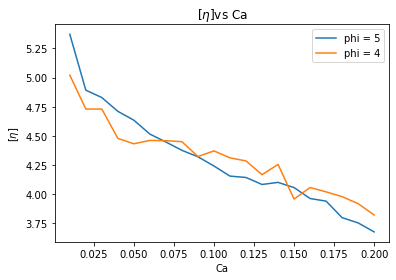

In [21]:
start_time = time.time()

#phis = [4.7, 3.8]
phis = [5, 4]
Ca_list = [(i+1)*0.01 for i in range(20)]
angles = [90, 60, 30, 0, -30, -60]

intrinsic_eta = np.zeros((len(phis), len(Ca_list)))
for phi_index, phi in enumerate(phis):
    for Ca_index, Ca in enumerate(Ca_list):
        #for angle_index, angle in enumerate(angles):
        intrinsic_eta[phi_index, Ca_index] = getInstrinsicViscosity(phi, Ca, 0, 2500)
            
#intrinsic_eta = intrinsic_eta/len(angles)

for phi_index, phi in enumerate(phis):
    plt.plot(Ca_list, intrinsic_eta[phi_index, :], label = ('phi = '+str(phi)))
plt.xlabel('Ca')
plt.ylabel(r'$\left[ \eta \right]$')
plt.legend()
plt.title(r'$\left[ \eta \right]$'+'vs Ca')

print('Total time elapsed = ', time.time()-start_time)

## Stress tensor vs Ca

In [ ]:
start_time = time.time()

results = np.zeros((9, 20))
str_id = ['xx', 'xy', 'xz', 'yx', 'yy', 'yz','zx','zy', 'zz']
Ca_list = [(i+1)*0.01 for i in range(20)]
for Ca in range(20):
    results[:,Ca] = getStress(5, (Ca+1)*0.01, 0, 2500)
f, axs = plt.subplots(3,3,figsize=(15,15))
for i in range(9):
    axs[i//3, i%3].plot(Ca_list, results[i,:])
    axs[i//3, i%3].set_title(str_id[i])
    
print('Total time elapsed = ', time.time()-start_time)

## Stress vs Ca (two-cell system)

Total time elapsed =  55.9757719039917


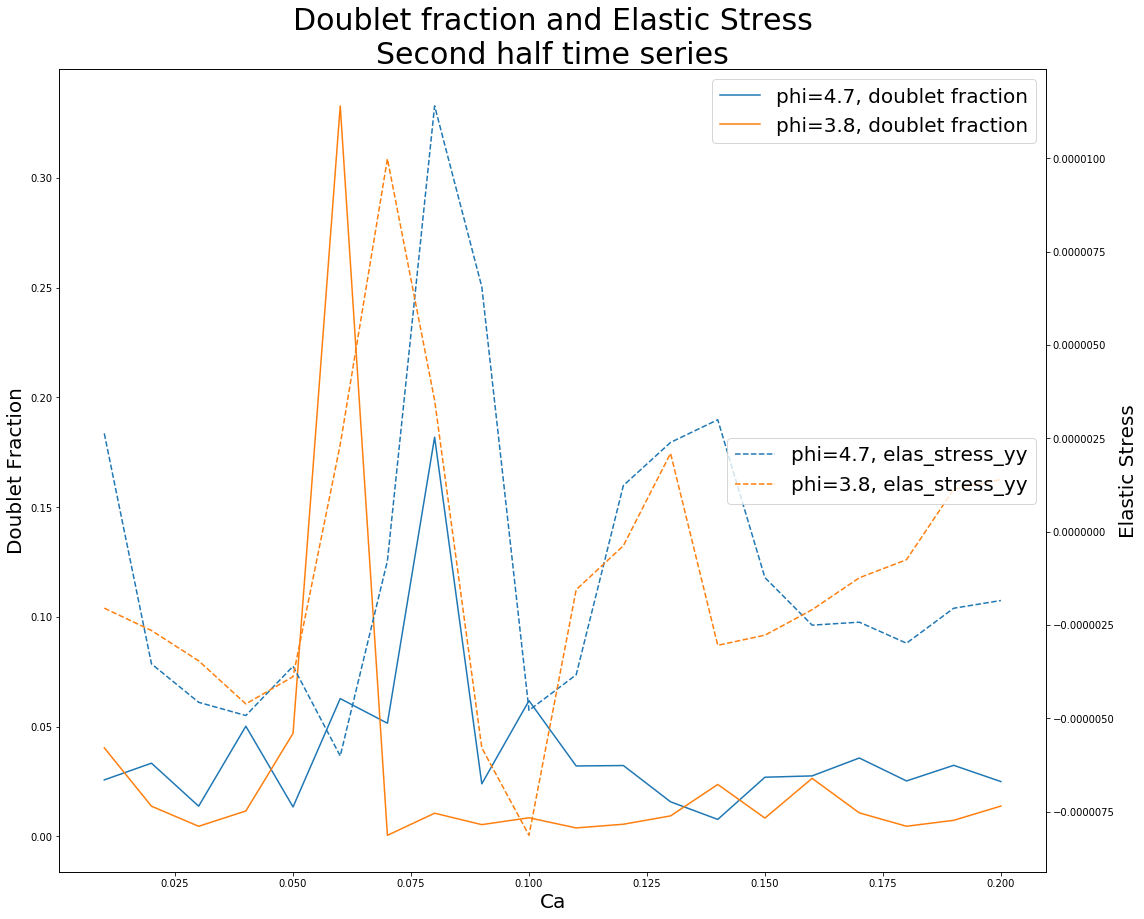

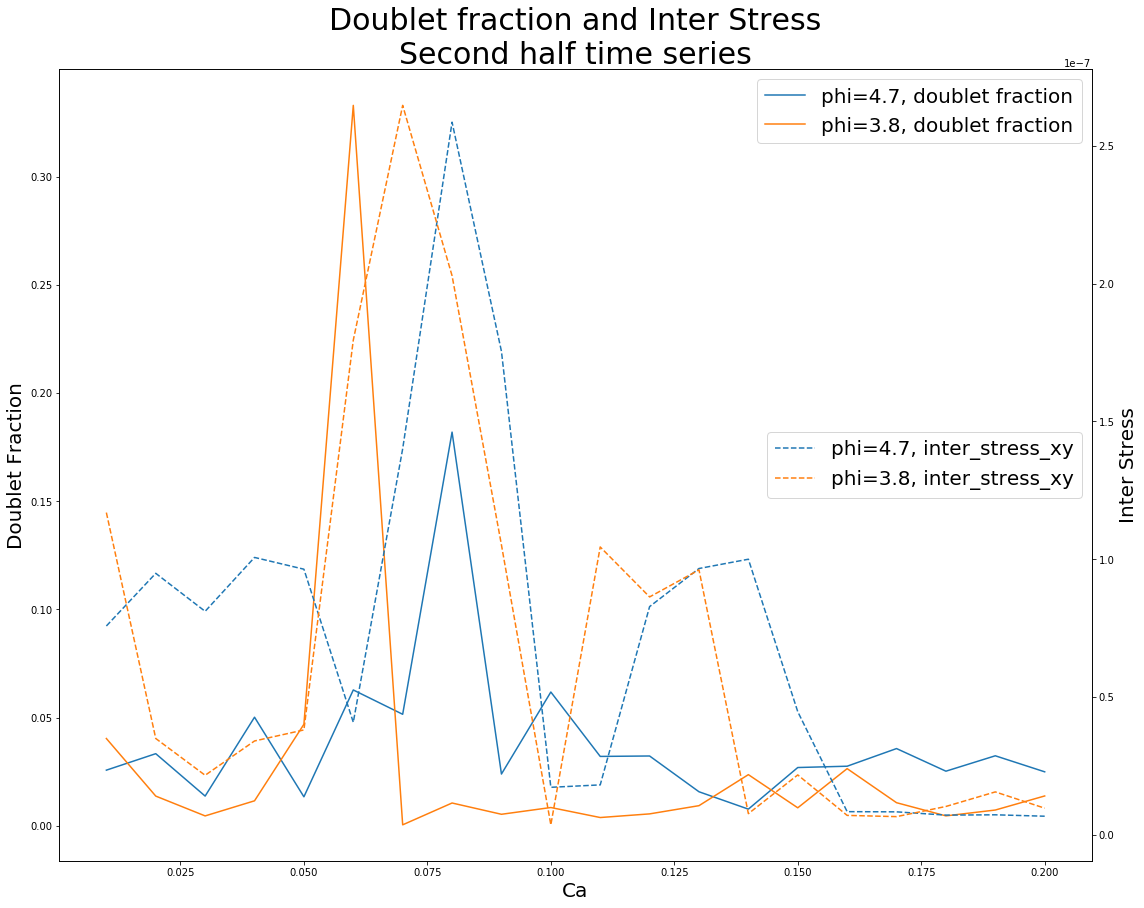

In [4]:
# Make mean stress (ensemble) versus Ca plot here
start_time = time.time()

ncycle = 2000
phis = [4.7, 3.8]
Ca_list = [(i+1)*0.01 for i in range(20)]
angles = [90, 60, 30, 0, -30, -60]
Dms = [1.0]
Ts = [1.0]
stress_aixs = ["xx", "xy", "xz", "yy", "yz", "zz"]
stress_avg = np.zeros((len(phis), 2, len(Ca_list)))
dfa = np.zeros((len(phis), len(Dms)*len(Ts), len(Ca_list)))
for phi_index, phi in enumerate(phis):
    for Ca_index, Ca in enumerate(Ca_list):
        for angle_index, angle in enumerate(angles):
            stress_avg[phi_index, 0, Ca_index] += getStress(phi, Ca, 0, 2000, angle, ncycle)[3]
            stress_avg[phi_index, 1, Ca_index] += getStress(phi, Ca, 1, 2000, angle, ncycle)[1]
            dfa[phi_index, :, Ca_index] += runAnalysis(phi, Ca, Ts, Dms, angle, ncycle)
dfa = dfa/len(angles) # average over the ensemble
stress_avg = stress_avg/len(angles)

fig1, ax1_1 = plt.subplots(figsize = (16, 12))

ax1_1.set_xlabel("Ca", fontsize = 20)
ax1_1.set_ylabel("Doublet Fraction", fontsize = 20)
ax1_1.plot(Ca_list, dfa[0, 0, :], Ca_list, dfa[1, 0, :])
ax1_1.tick_params(axis = 'y')

ax1_2 = ax1_1.twinx()  # instantiate a second axes that shares the same x-axis
ax1_2.set_ylabel("Elastic Stress", fontsize = 20)  # we already handled the x-label with ax1
ax1_2.plot(Ca_list, stress_avg[0, 0, :], Ca_list, stress_avg[1, 0, :], linestyle = '--')
ax1_2.tick_params(axis='y')
fig1.tight_layout()  # otherwise the right y-label is slightly clipped
ax1_1.set_title("Doublet fraction and Elastic Stress\nSecond half time series", fontsize = 30)      


ax1_1.legend(['phi=4.7, doublet fraction', 'phi=3.8, doublet fraction'], loc = 1, prop={'size': 20})
ax1_2.legend(['phi=4.7, elas_stress_yy', 'phi=3.8, elas_stress_yy'], loc = 5, prop={'size': 20})


fig2, ax2_1 = plt.subplots(figsize = (16, 12))

ax2_1.set_xlabel("Ca", fontsize = 20)
ax2_1.set_ylabel("Doublet Fraction", fontsize = 20)
ax2_1.plot(Ca_list, dfa[0, 0, :], Ca_list, dfa[1, 0, :])
ax2_1.tick_params(axis = 'y')

ax2_2 = ax2_1.twinx()  # instantiate a second axes that shares the same x-axis
ax2_2.set_ylabel("Inter Stress", fontsize = 20)  # we already handled the x-label with ax1
ax2_2.plot(Ca_list, stress_avg[0, 1, :], Ca_list, stress_avg[1, 1, :], linestyle = '--')
ax2_2.tick_params(axis='y')
fig2.tight_layout()  # otherwise the right y-label is slightly clipped
ax2_1.set_title("Doublet fraction and Inter Stress\nSecond half time series", fontsize = 30)      


ax2_1.legend(['phi=4.7, doublet fraction', 'phi=3.8, doublet fraction'], loc = 1, prop={'size': 20})
ax2_2.legend(['phi=4.7, inter_stress_xy', 'phi=3.8, inter_stress_xy'], loc = 5, prop={'size': 20})

fig1.savefig("./Pictures/DoubletFraction_ElasticStress_vs_Ca_second_half.png", dpi = 300, bbox_inches='tight')
fig2.savefig("./Pictures/DoubletFraction_InterparticleStress_vs_Ca_second_half.png", dpi = 300, bbox_inches='tight')

print('Total time elapsed = ', time.time()-start_time)

## Doublet fraction vs Ca

phi = 4.7, Ca = 0.01
phi = 4.7, Ca = 0.02
phi = 4.7, Ca = 0.03
phi = 4.7, Ca = 0.04
phi = 4.7, Ca = 0.05
phi = 4.7, Ca = 0.06
phi = 4.7, Ca = 0.07
phi = 4.7, Ca = 0.08
phi = 4.7, Ca = 0.09
phi = 4.7, Ca = 0.1
phi = 4.7, Ca = 0.11
phi = 4.7, Ca = 0.12
phi = 4.7, Ca = 0.13
phi = 4.7, Ca = 0.14
phi = 4.7, Ca = 0.15
phi = 4.7, Ca = 0.16
phi = 4.7, Ca = 0.17
phi = 4.7, Ca = 0.18
phi = 4.7, Ca = 0.19
phi = 4.7, Ca = 0.2
phi = 3.8, Ca = 0.01
phi = 3.8, Ca = 0.02
phi = 3.8, Ca = 0.03
phi = 3.8, Ca = 0.04
phi = 3.8, Ca = 0.05
phi = 3.8, Ca = 0.06
phi = 3.8, Ca = 0.07
phi = 3.8, Ca = 0.08
phi = 3.8, Ca = 0.09
phi = 3.8, Ca = 0.1
phi = 3.8, Ca = 0.11
phi = 3.8, Ca = 0.12
phi = 3.8, Ca = 0.13
phi = 3.8, Ca = 0.14
phi = 3.8, Ca = 0.15
phi = 3.8, Ca = 0.16
phi = 3.8, Ca = 0.17
phi = 3.8, Ca = 0.18
phi = 3.8, Ca = 0.19
phi = 3.8, Ca = 0.2
Total time elapsed =  245.67778205871582


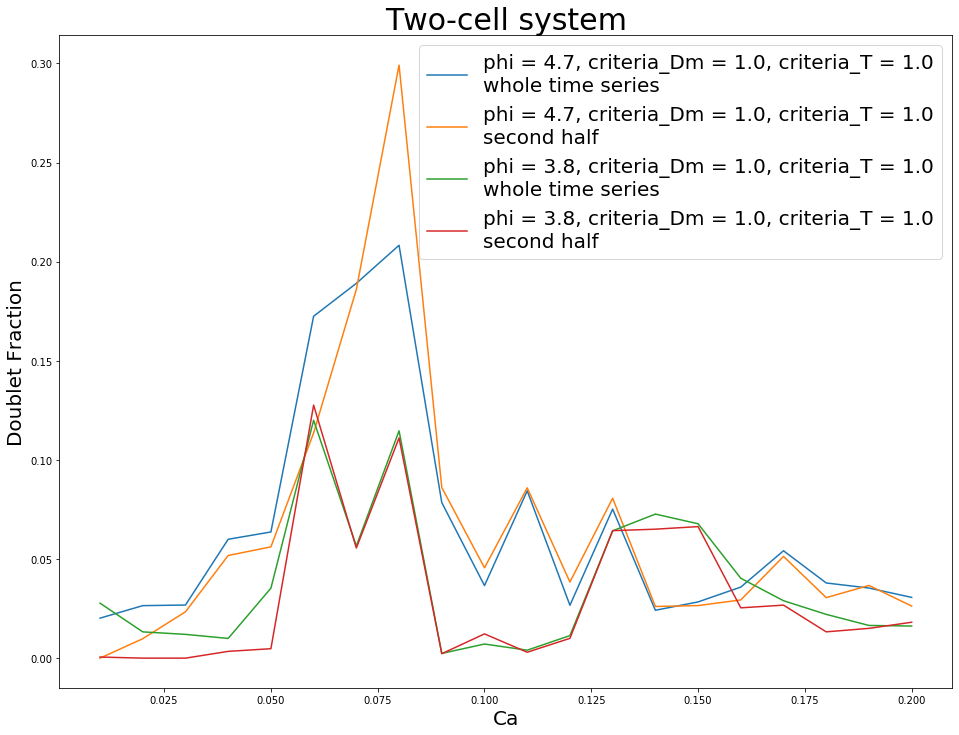

In [10]:
# Make mean doublet fraction (ensemble) versus Ca plot here

start_time = time.time()

ncycle = 2000
phis = [4.7, 3.8]
Dms = [1.0]
Ts = [1.0]
Ca_list = [(i+1)*0.01 for i in range(20)]
angles = [90-10*i for i in range(18)]
dfa = np.zeros((2, len(Dms)*len(Ts), len(Ca_list), 2))
for phi_index, phi in enumerate(phis):
    for Ca_index, Ca in enumerate(Ca_list):
        print("phi = {}, Ca = {}".format(phi, Ca))
        for angle_index, angle in enumerate(angles):
            result = runAnalysis(phi, Ca, Ts, Dms, angle, ncycle)
            dfa[phi_index, :, Ca_index, 0] += result[:, 0]
            dfa[phi_index, :, Ca_index, 1] += result[:, 1]
dfa = dfa/len(angles) # average over the ensemble

plt.figure(figsize = (16,12))
for phi_index, phi in enumerate(phis):
    for label_index in range(len(Dms)*len(Ts)):
        plt.plot(Ca_list, dfa[phi_index, label_index, :, 0],label = 'phi = {}, criteria_Dm = {}, criteria_T = {}\nwhole time series'
                 .format(phi, Dms[label_index//len(Dms)], Ts[label_index%len(Dms)]))
        plt.plot(Ca_list, dfa[phi_index, label_index, :, 1],label = 'phi = {}, criteria_Dm = {}, criteria_T = {}\nsecond half'
                 .format(phi, Dms[label_index//len(Dms)], Ts[label_index%len(Dms)]))
    
plt.xlabel("Ca", fontsize = 20)
plt.ylabel("Doublet Fraction", fontsize = 20)
plt.legend(prop={'size': 20})
plt.title("Two-cell system", fontsize = 30)
plt.savefig("./Pictures/TwoCellSystem_Doublet_Fraction_averageDF_vs_Ca_ncycle_{}.png".format(ncycle), dpi = 300)

print('Total time elapsed = ', time.time()-start_time)